In [1]:
import os, sys
import general_config 
print(general_config.ROOTDIR)
os.chdir(general_config.ROOTDIR)

In [2]:
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
config_data = {
    'folder_dir': '%s/%s'%(str(general_config.ROOTDIR),str('checkpoint/nscc.workflow4_0001v0.4.20200816')) ,
    'model_base_name':'workflow4_0001',
    'n_extra_layers':[1,2,3,4,5,6,7,8],
    'xai_modes': [
        'Saliency', 
        'InputXGradient', 
        'DeepLift', 
        'GradientShap',
        'DeepLiftShap',
    ],
    'branch_name_labels': [1],
}

In [4]:
def get_dataframe_by_branch_and_xai_mode(config_data, n_extra_layer, branch_no, xai_mode, csv_ext = 'csv'):
    model_name_by_neurons = '%s_%s'%(str(config_data['model_base_name']),str(100+n_extra_layer)[1:])
    branch_name = '%s.%s'%(str(model_name_by_neurons),str(branch_no))
    csv_dir = '%s/%s/%s/XAI_results/%s_%s.%s'%(str(config_data['folder_dir']), str(model_name_by_neurons), str(branch_name),
        str(branch_name), str(xai_mode), str(csv_ext))
    df = pd.read_csv(csv_dir)
    return df

from analysis.xai_analysis import get_stats_across_samples
def compile_stats_from_df_by_ypred(list_of_data_frames, y_pred, mean_precision=5, std_precision=3,sample_mode=None):
    stats = {
        'sAvePmu': [],                
        'sStdPmu': [], 
        'sAveRmu': [], 
        'sStdRmu': [], 
        'sAveAmu': [], 
        'sStdAmu': [], 
        'sAvePu': [],                 
        'sStdPu': [], 
        'sAveRu': [], 
        'sStdRu': [], 
        'sAveAu': [], 
        'sStdAu': [],      
    }
    for df in list_of_data_frames:
        df1 = df[df['y_pred']==y_pred]
        sstat, data_columns = get_stats_across_samples(df1, mean_precision=16, std_precision=16,sample_mode=sample_mode)
        for statkey in stats:
            stats[statkey].append(sstat[statkey])
            # print(statkey, len(stats[statkey]))
    return stats

In [7]:
def analyze_depth(config_data, xai_mode):
    compiled_data = {}
    for n_extra_layer in config_data['n_extra_layers']:
        if not n_extra_layer in compiled_data: compiled_data[n_extra_layer] = {}
        for y_pred in range(10):
            list_of_data_frames = []
            for j, branch_no in enumerate(config_data['branch_name_labels']):
                df = get_dataframe_by_branch_and_xai_mode(config_data, n_extra_layer, branch_no, xai_mode, csv_ext = 'csv')
                list_of_data_frames.append(df)

            compiled_data[n_extra_layer][y_pred] = compile_stats_from_df_by_ypred(list_of_data_frames, \
                y_pred, mean_precision=5, std_precision=3,sample_mode=None)
    
    plt.figure(figsize=(12,5))
    
    plt.gcf().add_subplot(121)
    color_scheme = np.linspace(0,1,len(compiled_data))
    for j, (n_extra_layer, data_by_layer) in enumerate(compiled_data.items()):
        mean_AvePmu, mean_AveRmu = 0,0
        n_classes = len(data_by_layer)
        for i, (y_pred, data_dict_by_y_pred) in enumerate(data_by_layer.items()):
            sAvePmu, sAveRmu = data_dict_by_y_pred['sAvePmu'], data_dict_by_y_pred['sAveRmu']
            # print(n_extra_layer, y_pred, len(data_dict_by_y_pred))
            plt.gca().scatter(sAvePmu, sAveRmu, s=3,color=(1-color_scheme[j],0,color_scheme[j]))
            mean_AvePmu += np.mean(sAvePmu)/n_classes
            mean_AveRmu += np.mean(sAveRmu)/n_classes
        plt.gca().scatter(mean_AvePmu, mean_AveRmu, s=24, marker='x',color=(1-color_scheme[j],0,color_scheme[j]))
    plt.gca().set_xlabel('%s'%(str('$P_{\mu}$')))
    plt.gca().set_ylabel('%s'%(str('$R_{\mu}$')))
    
    plt.gcf().add_subplot(122)
    color_scheme = np.linspace(0,1,len(compiled_data))
    for j, (n_extra_layer, data_by_layer) in enumerate(compiled_data.items()):
        mean_AvePu, mean_AveRu = 0,0
        n_classes = len(data_by_layer)
        for i, (y_pred, data_dict_by_y_pred) in enumerate(data_by_layer.items()):
            sAvePu, sAveRu = data_dict_by_y_pred['sAvePu'], data_dict_by_y_pred['sAveRu']
            # print(n_extra_layer, y_pred, len(data_dict_by_y_pred))
            
            this_label = '%s'%(str(n_extra_layer)) if i==0 else None
            plt.gca().scatter(sAvePu, sAveRu, s=3,color=(1-color_scheme[j],0,color_scheme[j]),label=this_label)
            mean_AvePu += np.mean(sAvePu)/n_classes
            mean_AveRu += np.mean(sAveRu)/n_classes
        plt.gca().scatter(mean_AvePu, mean_AveRu, s=24, marker='x',color=(1-color_scheme[j],0,color_scheme[j]))  
    plt.gca().set_xlabel('%s'%(str('$P_{\mu}$')))
    plt.gca().set_ylabel('%s'%(str('$R_{\mu}$')))
    plt.legend( bbox_to_anchor=(1.04,1))
    plt.show()

Saliency


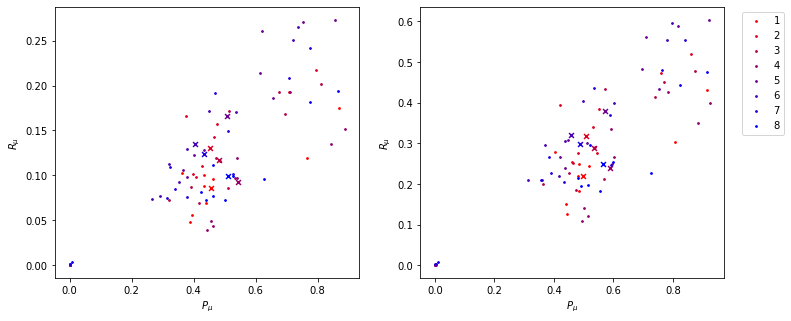

InputXGradient


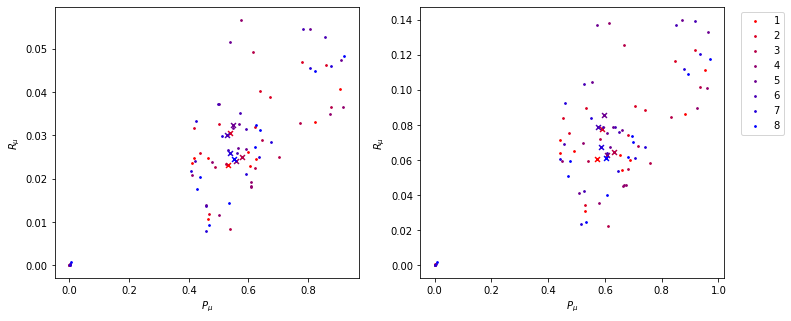

DeepLift


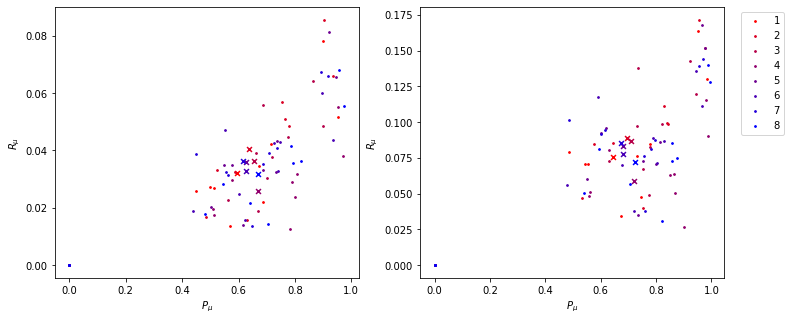

GradientShap


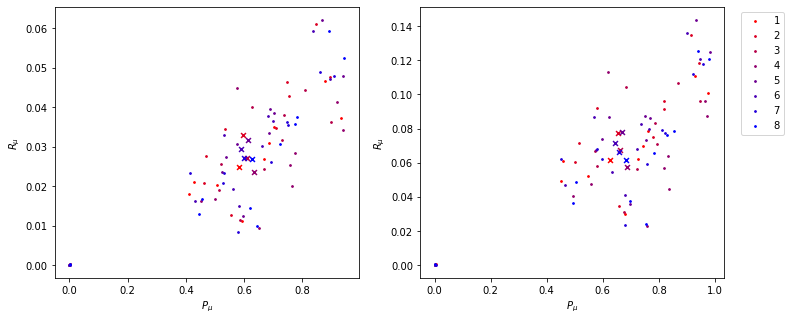

DeepLiftShap


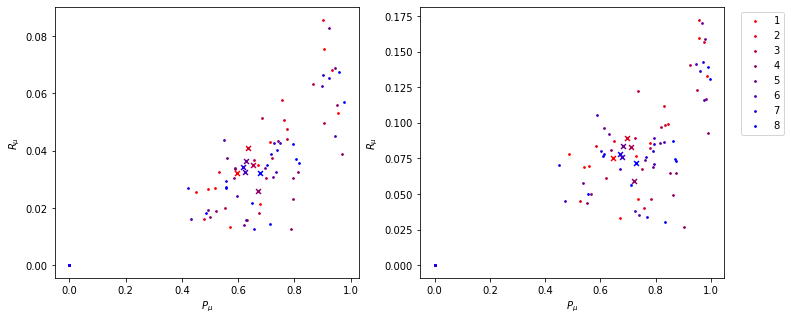

In [8]:
for xai_mode in config_data['xai_modes']:
    print(xai_mode)
    analyze_depth(config_data, xai_mode)